In [2]:
# Standard imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'matplotlib'

In [91]:
def returnFaceBox(img_filename: str, model: cv2.dnn_Net) -> list:
    inputImg = cv2.imread(img_filename)
    (h, w) = inputImg.shape[:2]
    #get our blob which is our input image 
    blob = cv2.dnn.blobFromImage(cv2.resize(inputImg, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    #input the blob into the model and get back the detections 
    model.setInput(blob)
    detections = model.forward()
    #Iterate over all of the faces detected and extract their start and end points
    count = 0

    bbox = []
    max_area = 0 
    #print(detections)
    #bbox_list = []
    for i in range(0, detections.shape[2]):
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        confidence = detections[0, 0, i, 2]
        #if the algorithm is more than 16.5% confident that the      detection is a face, show a rectangle around it
        if (confidence > 0.165):
            #print(detections[0, 0, i, :])
            area = (endY - startY) * (endX - startX)
            
            if area > max_area: 
                if max(startY, endY) <= inputImg.shape[1] and max(startX, endX) <= inputImg.shape[0]:
                    bbox = [startX, startY, endX, endY]
                    #bbox_list.append(bbox)
                    max_area = area
            #print(confidence)
    
    #cv2.rectangle(inputImg, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)          
    return inputImg, bbox #, bbox_list

In [124]:
def faceCombine(img1: np.ndarray, face1: list, img2: np.ndarray, face2: list, xoffset: int = 0, yoffset: int = 0, filename: str = "sample.jpg") ->  (np.ndarray, np.ndarray):
    
    plt.figure(figsize = (15,10))

    start_y = face1[1]-30
    end_y = face1[3]+30
    start_x = face1[0]-30
    end_x = face1[2]+30

    crop_img = img1[start_y:end_y, start_x:end_x]

    src_mask = np.zeros((crop_img.shape[0], crop_img.shape[1], 3), np.uint8)

    poly = np.array([ [30, 30], [end_x-start_x-30, 30], 
                      [end_x-start_x - 30, end_y-start_y - 30],
                      [30, end_y-start_y-30]], np.int32)


    cv2.fillPoly(src_mask, [poly], (125, 255, 255))

    src_mask = cv2.resize(src_mask,None,fx=2, fy=2, interpolation = cv2.INTER_AREA)
    crop_img = cv2.resize(crop_img,None,fx=2, fy=2, interpolation = cv2.INTER_AREA)

    face1_x_len = face1[2] - face1[0]
    face1_y_len = face1[3] - face1[1]
    face2_x_len = face2[2] - face2[0]
    face2_y_len = face2[3] - face2[1]

    x_ratio_face1 = face1_x_len / face2_x_len
    y_ratio_face1 = face1_y_len / face2_y_len

    src_mask = cv2.resize(src_mask,None,fx=1/x_ratio_face1,fy=1/y_ratio_face1, interpolation = cv2.INTER_AREA)
    crop_img = cv2.resize(crop_img,None,fx=1/x_ratio_face1,fy=1/y_ratio_face1, interpolation = cv2.INTER_AREA)

    img2 = cv2.resize(img2,None,fx=2, fy=2, interpolation = cv2.INTER_AREA)

    face2 = [x * 2 for x in face2]
    face2_y_len = face2[3] - face2[1]  # face2[3] - face2[1]
    face2_x_len = face2[2] - face2[0] 

    #center = (face2[2] , face2[3] + int(face2_y_len / 2))

    center = (face2[0] + int(face2_x_len/2 ), face2[1] + int(face2_y_len / 2) + yoffset)

    # Clone seamlessly.
    #mage_crop = imst[]

    #cv2.fillPoly(img2, pts =[poly], color=(255,255,255))
    output = cv2.seamlessClone(crop_img, img2, src_mask, center, cv2.MIXED_CLONE) # NORMAL_CLONE MIXED_CLONE


    #cv2.circle(output,(center), 20, (255,255,0), -1)
    if 1:
        #plt.imshow(output)
        #plt.axis('off')
        #plt.show()

        cv2.imwrite("../../data/imgs/" + filename, output);
        return output

[62, 62, 158, 192] [329, 176, 853, 910]


<Figure size 1080x720 with 0 Axes>

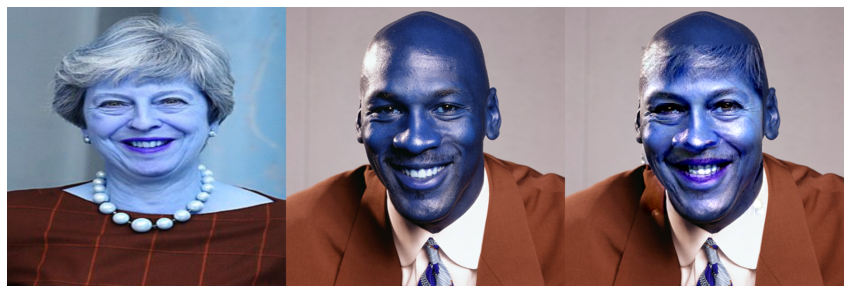

In [125]:
# face_model:
detector_model = "../../data/dnn/res10_300x300_ssd_iter_140000.caffemodel"
detector_weights= "../../data/dnn/deploy.prototxt.txt"
model = cv2.dnn.readNetFromCaffe(detector_weights, detector_model)

if 0:
    im_cd, bbox_cd = returnFaceBox("../../data/imgs/craig_david0.jpg", model)
    im_jm, bbox_jm = returnFaceBox("../../data/imgs/mcbain.jpg", model)
    im_st, bbox_st = returnFaceBox("../../data/imgs/sammy_boi.jpg", model)

    #faceSwap(im_cd, bbox_cd, im_jm, bbox_jm)
    #faceSwap(im_st, bbox_st, im_jm, bbox_jm, 0,- 28)

filename = "sample.jpg"
#faceSwap(im_jm, bbox_jm, im_st, bbox_st, 0, 28, filename)

im_1, bbox_1 = returnFaceBox("../../data/imgs/jg.jpg", model)
im_1, bbox_1= returnFaceBox("../../data/imgs/putin.jpg", model)
im_2, bbox_2 = returnFaceBox("../../data/imgs/mj.jpg", model)
im_1, bbox_1 = returnFaceBox("../../data/imgs/theresa_may.jpg", model)


print(bbox_1, bbox_2)
filename = "combined.jpg"
im_comb = faceCombine(im_1, bbox_1, im_2, bbox_2, 0, -30, filename)
#im_comb = faceCombine(im_2, bbox_2, im_1, bbox_1, 0, 0, filename)

if 1:
    #im_comb = faceCombine(im_wil, bbox_wil, im_dad, bbox_dad, 0, 0, filename)
    im_1 = cv2.resize(im_1, (640, 640)) 
    im_2 = cv2.resize(im_2, (640, 640)) 
    im_comb = cv2.resize(im_comb, (640, 640)) 
    total_img = cv2.hconcat(src=[im_1, im_2, im_comb])
plt.figure(figsize = (15,10))
#plt.imshow(im_wil)
plt.imshow(total_img)
plt.axis('off')
plt.show()
cv2.imwrite("../../data/imgs/" + filename, total_img);